In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import torch as pt
import torch.nn as nn

import types
import numbers

# pt.autograd.set_detect_anomaly(False)

In [2]:
def V_step(V, F):
    """
    Computes next position given current position and forcing inputs
    V: car's current position in 6D space, (x , y, theta, s, omega, t)
    F: current forcing inputs, (phi, psi, dt)
    """
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct

    # V1 = A + phi*B + psi*C + dt*D
    # return pt.clamp(V1,
    #     min=pt.tensor([-pt.inf, -pt.inf, -pt.inf, 0, -2, -pt.inf]),
    #     max=pt.tensor([pt.inf, pt.inf, pt.inf, pt.inf, 2, pt.inf]))

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    """
    Returns smallest angular difference in (0, pi) between two angles
    """
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def get_forcing(V, F):
    """
    Returns true forcings from logits
    """
    # limits based on current speed
    limits_min = pt.tensor([-0.8, -0.8, 0.001], device=F.device)
    limits_max = pt.tensor([0.8, 0.8, 0.25], device=F.device)
    return limits_min + (limits_max - limits_min) * pt.sigmoid(F)

def to_tensor(V_mat):
    """
    Splits V_mat into position components (5D) and time component (1D)
    """
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

def to_lambda(schedule):
    if schedule is None:
        return lambda x, target_loss: 0
    if isinstance(schedule, numbers.Number):
        return lambda x, target_loss: schedule
    if callable(schedule):
        return schedule
    raise TypeError(f'Invalid schedule type: {type(schedule)}. Expected None, a number, or a function.')

In [3]:
def multi_loss_fun(Y, T, F, scale=None):
    """
    Y: final state (6D: x, y, theta, s, omega, t)
    T: target (2D or 5D)
    F: list of forcings
    """
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T[0:5])
    diff[2] = angle_diff(Y[2], T[2])
    position_loss = pt.sum(diff * diff * scale)       # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(pt.stack(F)[:,0:2]**2)        # loss by using too much force
    return position_loss, time_loss, l2_loss


def compute_multi_path_autograd(V0, F_logits, target):
    """
    Computes entire path given initial position and logits of forcings. Computes loss given target.
    V0: initial position
    F_logits: logits of forcing terms
    target: target position in 5D space
    """
    V_list = [V0]    # trajectory as a list of position vectors
    F_true = []      # forcing terms as a list of forcing vectors

    for i in range(F_logits.shape[0]):
        F_true.append(get_forcing(V_list[-1], F_logits[i]))
        V_list.append(V_step(V_list[i], F_true[i]))

    loss = multi_loss_fun(V_list[-1], target, F_true, scale=pt.tensor([1, 1, 1, 1, 1]))

    return V_list, loss

In [4]:
def optimizeMultiPath(v0, target, F_logits, checkpoint_2d=None, checkpoint_dof=None, iters=500, fine_tuning_steps=50, plot_freq=50,
        lr=9e-2, l2_rate=-1e0, time_rate=2e-8, reverse_rate=0.5, show_logs=True
    ):
    """
    Iteratively performs GD to optimize forcings
    
    v0: starting tensor in 6d (v0[5]=0)
    checkpoint_2d: num_checkpoints x 2 tensor containing fixed points in 2d
    target: ending tensor in 5d
    checkpoint_dof: num_checkpoints x 3 tensor containing learnable dfs at start of segments
    F_logits: list (length = number of checkpoints + 1)
                each element is a n_steps x 3 tensor of forcing terms
    """
    lr = to_lambda(lr)
    l2_rate = to_lambda(l2_rate)
    time_rate = to_lambda(time_rate)
    reverse_rate = to_lambda(reverse_rate)

    n_segments = checkpoint_2d.shape[0] + 1 if checkpoint_2d is not None else 1
    n_intermediate_segments = n_segments - 2
    num_logs = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1

    optim = pt.optim.Adam(F_logits + [checkpoint_dof]) if checkpoint_dof is not None else pt.optim.Adam(F_logits)

    V_mat = []
    ts_mat = []
    F_true = []
    loss_logs = pt.zeros((num_logs, n_segments, 4)) # pos, time, l2, reverse

    for i in range(iters):
        is_log_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
        log_idx = i // plot_freq
        
        if is_log_step:
            # log v, ts, and F on current iteration's path
            v_path = []
            ts_path = []
            F_true_path = []

        loss = 0
        x = i / (iters - fine_tuning_steps)

        # compute first segment
        optim.zero_grad()

        end = pt.cat([checkpoint_2d[0], checkpoint_dof[0], pt.zeros(1, device=v0.device)], dim=0) if checkpoint_dof is not None else target
        traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(v0, F_logits[0], end)

        # compute loss
        l2_coef = l2_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        time_coef = time_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        reverse_coef = reverse_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
                

        #reverse_loss = pt.mean(pt.clamp(pt.stack(traj)[:,3], max=0.0)**2)
        #reverse_loss = pt.mean(pt.sigmoid(-10 * pt.stack(traj)[:,3]))
        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))

        if is_log_step:
            v_segment, ts_segment = to_tensor(traj)
            v_path.append(v_segment)
            ts_path.append(ts_segment)
            F_true_path.append(get_forcing(traj[:-1], F_logits[0][:, :]))
            loss_logs[log_idx,0,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss])

        if n_segments == 1:
            loss += position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss
        else:
            loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss

        for j in range(n_intermediate_segments+1):
            start = end
            if j == n_segments-2:
                end = target
            else:
                end = pt.cat([checkpoint_2d[j+1], checkpoint_dof[j+1], pt.zeros(1, device=v0.device)], dim=0)

            traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(start, F_logits[j+1], end)

            #reverse_loss = pt.mean(pt.clamp(pt.stack(traj)[:,3], max=0.0)**2)
            #reverse_loss = pt.mean(pt.sigmoid(-10 * pt.stack(traj)[:,3]))
            reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))


            if is_log_step:
                v_segment, ts_segment = to_tensor(traj)
                v_path.append(v_segment)
                ts_path.append(ts_segment)
                F_true_path.append(get_forcing(traj[:-1], F_logits[j+1][:, :]))
                loss_logs[log_idx,j+1,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss])

            if j == n_segments - 2:
                # no coefficient on position_loss because we don't need to enforce continuity as strictly at the end
                loss += position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss
            else:
                loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss

        if is_log_step:
            V_mat.append(v_path)
            ts_mat.append(ts_path)
            F_true.append(F_true_path)

        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, position_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()


        # plot solution every plot_freq steps
        if show_logs and is_log_step:
            
            print(f'Iteration {i+1}, Mean Position Dist: {loss_logs[log_idx, :, 0].mean() ** 0.5:.3f},  '\
                   f'End Time: {loss_logs[log_idx,:,1].sum():.3f},  '\
                   f'L2: {loss_logs[log_idx,:,2].mean():.3f},  '\
                   f'Reverse Loss: {loss_logs[log_idx,:,3].mean():.3f}')
                   
    return F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs

In [5]:
def cat_ts(ts_mat):
    """
    Concatenates segment timesteps for each iteration
    ts_mat: list of lists (n_logs x n_segments)
            each sublist holds n_segments tensors
            each tensor holds times for each segment (n_steps+1)
            may have variable size depending on n_steps for each segment
    """
    num_logs = len(ts_mat)
    num_segments = len(ts_mat[0])
    total_steps = pt.tensor([len(ts_mat[0][n]) for n in range(num_segments)]).sum() - num_segments    
    
    ts_cat = pt.zeros(num_logs, total_steps+1)

    for i in range(num_logs):        
        ts_path = [ts_mat[i][0]]

        prev_time = ts_path[0][-1].item()

        for j in range(1, num_segments):
            ts_path.append(ts_mat[i][j][1:] + prev_time)
            prev_time = ts_path[j][-1]
        
        ts_cat[i,:] = pt.cat(ts_path)
    
    return ts_cat



def cat_F(F_true):
    """
    Concatenates segment forcings for each iteration
    F_true: list of lists (num_logs x n_segments)
            each sublist holds n_segments tensors
            each tensor holds phi, psi, and dt for each segment (n_steps x 3) variable size depending on n_steps
    """
    return pt.stack([pt.cat(F_true[i]) for i in range(len(F_true))], dim=0)

In [6]:
def color_map(n_segments, cmap_name='viridis', vmin=0, vmax=1):
    """
    returns list of n_segments colors
    """
    cmap = plt.get_cmap(cmap_name)
    return [cmap((i / max(n_segments - 1, 1)) * (vmax-vmin) + vmin) for i in range(n_segments)]

def plot_traj(V_mat, target, checkpoint_2d=None, checkpoint_dof=None, dof_init=None, 
              ax=None, alphas=None, colors=None, cmap='viridis', vmin=0, vmax=1, figsize=(8,6)):
    """
    Plots trajectories of car on existing axes object or creates new one
    V_mat: list of lists (n_logs x n_segments)
           each sublist holds n_segments 5D tensors
           each 5D tensor holds position sequence of each segment for a given iteration
    target: target position in 5D space
    checkpoint_2d: tensor of 2D checkpoints (n_checkpoints x 2) (optional)
    checkpoint_dof: tensor of 3D checkpoint degrees of freedom theta, s omega (n_checkpoints x 3) (optional)
    dof_init: intitializations of checkpoint_dof (optional)
    """
    colors = color_map(len(V_mat[0]), cmap_name=cmap, vmin=vmin, vmax=vmax) if colors is None else colors
    if alphas is None:
        alphas = np.ones(len(V_mat))
        alphas[:-1] = np.linspace(0.1, 0.8, len(V_mat)-1)
        
    arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

    full_checkpoint = pt.cat([checkpoint_2d, checkpoint_dof], dim=1).detach() if checkpoint_2d is not None else None

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True


    ax.scatter(*V_mat[0][0][0,0:2], marker='*', color='sandybrown', s=360, label='Start')
    ax.arrow(*V_mat[0][0][0,0:2], *arrowDir(V_mat[0][0][0,:]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)

    if checkpoint_2d is not None:
        ax.scatter(checkpoint_2d[:,0], checkpoint_2d[:,1], marker='X', color='sandybrown', s=400, lw=0.8, label='Checkpoint')


    for i in range(len(V_mat)):
        lw = 2 if alphas[i] == 1 else 1.5
        # plot first segment
        ax.plot(V_mat[i][0][:,0], V_mat[i][0][:,1], lw=lw, color=colors[0], alpha=alphas[i], zorder=4)
        if i == len(V_mat)-1:
            if checkpoint_2d is not None:
                ax.scatter(*V_mat[i][0][-1,0:2], marker='x', color=colors[0], s=400, lw=2, zorder=6)
            ax.arrow(*V_mat[i][0][-1,0:2], *arrowDir(V_mat[i][0][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[0], alpha=alphas[i], zorder=6)

        # plot subsequent segments
        for j in range(len(V_mat[i])-1):
            ax.plot(V_mat[i][j+1][:,0], V_mat[i][j+1][:,1], lw=lw, color=colors[j+1], alpha=alphas[i], zorder=4)
            if i == len(V_mat)-1:
                if full_checkpoint is not None:
                    ax.arrow(*checkpoint_2d[j], *arrowDir(full_checkpoint[j]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
                if j != len(V_mat[i])-2:
                    ax.scatter(*V_mat[i][j+1][-1,0:2], marker='x', color=colors[j+1], s=400, lw=2, zorder=6)
                ax.arrow(*V_mat[i][j+1][-1,0:2], *arrowDir(V_mat[i][j+1][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[j+1], alpha=alphas[i], zorder=6)
                if dof_init is not None:
                    ax.arrow(*checkpoint_2d[j], dof_init[j,1]*np.cos(dof_init[j,0]), dof_init[j,1]*np.sin(dof_init[j,0]),
                             head_width=0.15, head_length=0.15, lw=4, color='black', zorder=5, label='Initial Guess')



    ax.scatter(*target[0:2],  marker='s', color='sandybrown', s=240, label='Target')
    ax.arrow(*target[0:2], *arrowDir(target), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
    ax.scatter(*V_mat[-1][-1][-1,0:2], marker='D', color=colors[-1], s=160, label='End', zorder=6)
    ax.arrow(*V_mat[-1][-1][-1,0:2], *arrowDir(V_mat[-1][-1][-1,:]), head_width=0.1, head_length=0.1, lw=3, color=colors[-1], zorder=6)


    # sort legend labels
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    order = [0, 1, 3, 2, 4] if checkpoint_2d is not None else range(3)
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ordered_handle_list = []
    ordered_label_list = []
    [ordered_handle_list.append(handle_list[idx]) for idx in order if handle_list[idx] not in ordered_handle_list]
    [ordered_label_list.append(label_list[idx]) for idx in order if label_list[idx] not in ordered_label_list]

    ax.legend(ordered_handle_list, ordered_label_list, labelspacing=1.5, fontsize=14)
    ax.set_title('Car Trajecotry', fontsize=16)
    ax.set_xlabel('X Position', fontsize=14)
    ax.set_ylabel('Y Position', fontsize=14)
    ax.grid()
    return (fig, ax) if fig_exists is True else ax


def plot_forcing(F_cat, ts_cat, n_steps, ax=None, alphas=None, colors=None, figsize=(8,6)):
    """
    Plots evolution of forcing terms on existin axes object or creates a new one
    F_cat: tensor of concatenated true forcings (n_logs x total_steps x 3)
    ts_cat: tensor of times for each log (n_logs x total_steps)
    n_stesp: number of timesteps for each segment
    """
    alphas = np.linspace(0.1, 0.8, F_cat.shape[0]-1) if alphas is None else alphas
    colors = ['deeppink', 'limegreen'] if colors is None else colors

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True
    
    for i in range(ts_cat.shape[0]-1):
        lw = 2 if alphas[i] == 1 else 1.5
        ax.plot(ts_cat[i,:-1], F_cat[i,:,0].detach().numpy(), color=colors[0], alpha=alphas[i], lw=lw, zorder=0)
        ax.plot(ts_cat[i,:-1], F_cat[i,:,1].detach().numpy(), color=colors[1], alpha=alphas[i], lw=lw, zorder=1)

    ax.plot(ts_cat[-1,:-1], F_cat[-1,:,0].detach().numpy(), color=colors[0], alpha=1, lw=2, zorder=0, label='Acceleration Force')
    ax.plot(ts_cat[-1,:-1], F_cat[-1,:,1].detach().numpy(), color=colors[1], alpha=1, lw=2, zorder=1, label='Turning Force')

    left, right = ax.get_xlim()
    ax.plot([left, right], [0.8, 0.8], '--k', lw=2)
    ax.plot([left, right], [-0.8, -0.8], '--k', lw=2)

    steps_taken = 0
    for step in n_steps:
        steps_taken += step
        ax.plot(2*[ts_cat[-1, steps_taken]], [-0.8, 0.8], '--k', lw=2)


    ax.set_title('Forcing Inputs', fontsize=16)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Force', fontsize=14)
    ax.set_xlim(left, right)
    ax.grid()
    ax.legend(fontsize=14)

    return (fig, ax) if fig_exists is True else ax

### One segment path (no checkpoints)

In [7]:
# og path
v0 = v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

n_steps = pt.tensor([32])

dt_max = 0.25
t_final = n_steps.item()*dt_max

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               reverse_rate=0,
                                                                               iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 1.220,  End Time: 4.021,  L2: 0.302,  Reverse Loss: 0.000
Iteration 100, Mean Position Dist: 0.301,  End Time: 4.359,  L2: 0.326,  Reverse Loss: 0.000
Iteration 150, Mean Position Dist: 0.246,  End Time: 4.460,  L2: 0.334,  Reverse Loss: 0.000
Iteration 200, Mean Position Dist: 0.199,  End Time: 4.458,  L2: 0.340,  Reverse Loss: 0.000
Iteration 250, Mean Position Dist: 0.098,  End Time: 4.479,  L2: 0.348,  Reverse Loss: 0.000
Iteration 300, Mean Position Dist: 0.029,  End Time: 4.486,  L2: 0.368,  Reverse Loss: 0.000
Iteration 350, Mean Position Dist: 0.020,  End Time: 4.459,  L2: 0.391,  Reverse Loss: 0.000
Iteration 400, Mean Position Dist: 0.024,  End Time: 4.429,  L2: 0.413,  Reverse Loss: 0.000
Iteration 450, Mean Position Dist: 0.028,  End Time: 4.402,  L2: 0.433,  Reverse Loss: 0.000
Iteration 500, Mean Position Dist: 0.

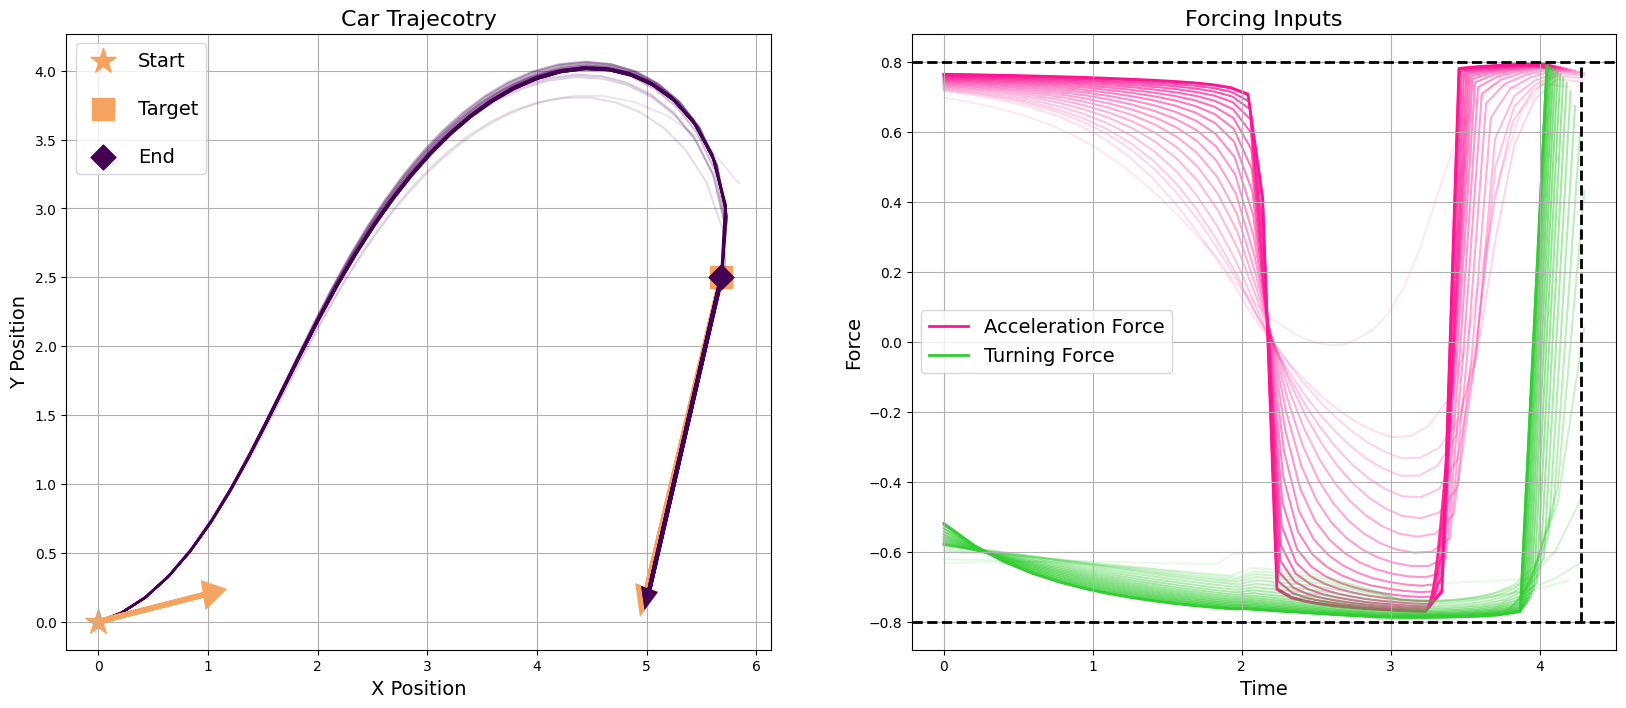

In [8]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Two segment path (one checkpoint)

In [9]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[7, 5]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = pt.tensor([32, 32])

checkpoint_dof_init = pt.tensor([[np.pi/2, 1,0.5]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               iters=1000)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[7.0000, 5.0000, 1.5708, 1.0000, 0.5000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 1.570,  End Time: 9.720,  L2: 0.196,  Reverse Loss: 0.017
Iteration 100, Mean Position Dist: 0.541,  End Time: 11.109,  L2: 0.251,  Reverse Loss: 0.009
Iteration 150, Mean Position Dist: 0.473,  End Time: 11.048,  L2: 0.249,  Reverse Loss: 0.004
Iteration 200, Mean Position Dist: 0.411,  End Time: 11.134,  L2: 0.255,  Reverse Loss: 0.002
Iteration 250, Mean Position Dist: 0.344,  End Time: 11.260,  L2: 0.269,  Reverse Loss: 0.002
Iteration 300, Mean Position Dist: 0.418,  End Time: 11.377,  L2: 0.290,  Reverse Loss: 0.002
Iteration 350, Mean Position Dist: 0.247,  End Time: 11.446,  L2: 0.313,  Reverse Loss: 0.002
Iteration 400, Mean Position Dist: 0.208,  End Time: 11.534,  L2: 0.334,  Reverse Loss: 0.003
Iteration 450, Mean Position Dist: 0.180,  End Time: 1

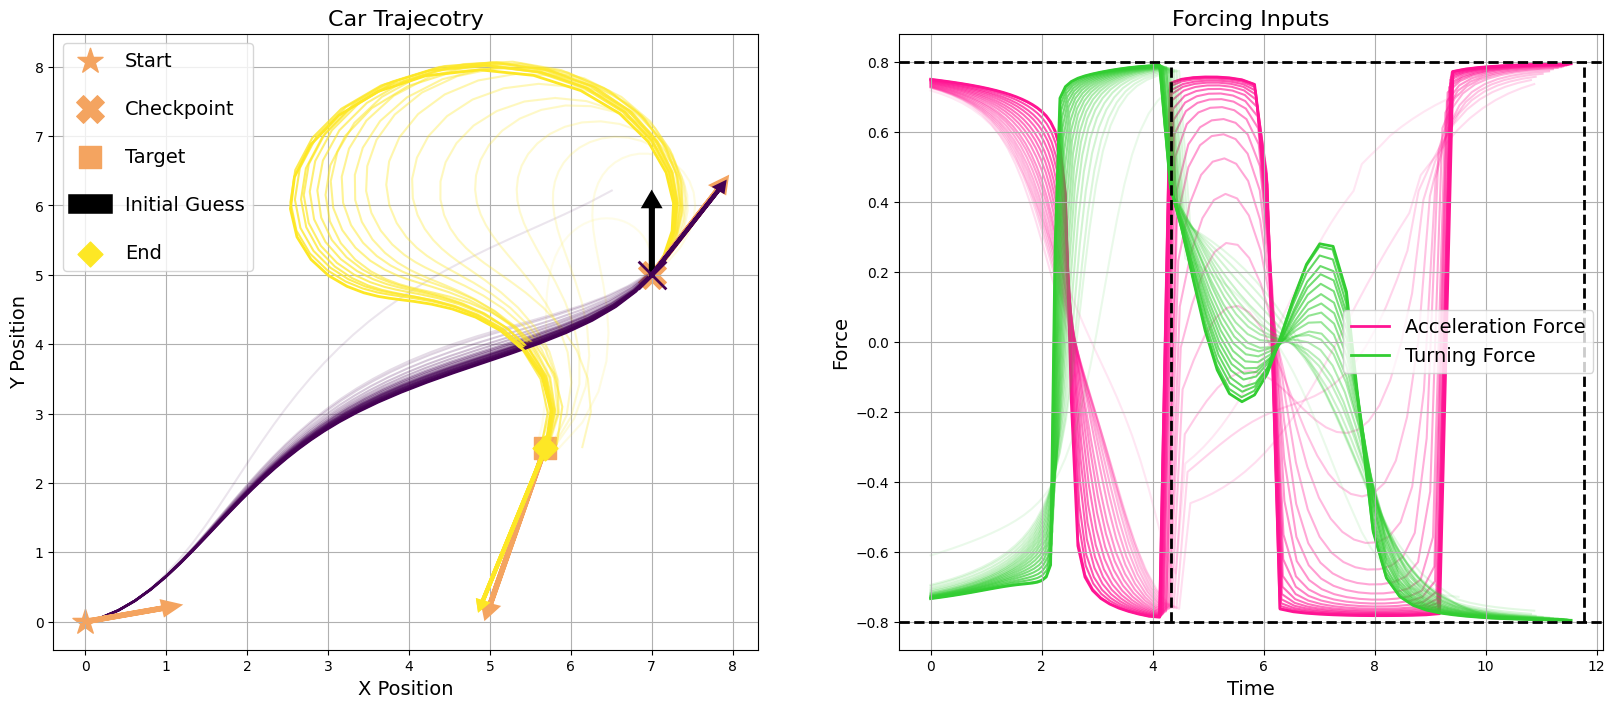

In [10]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

plot_traj(V_mat, target, checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, dof_init=checkpoint_dof_init, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Three segment paths (two checkpoints)

In [11]:
n_steps = pt.tensor([32, 32, 16])

dt_max = 0.25

tf = n_steps.sum()*dt_max

v0 = pt.tensor([0, 0, -0.2, 0.5, 0, 0])
checkpoint_2d = pt.tensor([[4, -4],
                           [8, 4]])
target = pt.tensor([11, 8, np.pi/8, 2.5, -0.2])

checkpoint_dof_init = pt.tensor([[-np.pi/8, 0.5, 0],
                                 [3*np.pi/8, 0.5, -0.5]])

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]
checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone()) 


print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               reverse_rate=0,
                                                                               iters=1000)

Start: tensor([ 0.0000,  0.0000, -0.2000,  0.5000,  0.0000,  0.0000])
Checkpoint Guess: tensor([[ 4.0000, -4.0000, -0.3927,  0.5000,  0.0000],
        [ 8.0000,  4.0000,  1.1781,  0.5000, -0.5000]])
Target: tensor([11.0000,  8.0000,  0.3927,  2.5000, -0.2000])

Iteration 50, Mean Position Dist: 0.526,  End Time: 11.863,  L2: 0.094,  Reverse Loss: 0.005
Iteration 100, Mean Position Dist: 0.145,  End Time: 12.213,  L2: 0.107,  Reverse Loss: 0.006
Iteration 150, Mean Position Dist: 0.055,  End Time: 12.355,  L2: 0.124,  Reverse Loss: 0.006
Iteration 200, Mean Position Dist: 0.051,  End Time: 12.296,  L2: 0.144,  Reverse Loss: 0.006
Iteration 250, Mean Position Dist: 0.049,  End Time: 12.147,  L2: 0.171,  Reverse Loss: 0.006
Iteration 300, Mean Position Dist: 0.051,  End Time: 11.979,  L2: 0.204,  Reverse Loss: 0.006
Iteration 350, Mean Position Dist: 0.051,  End Time: 11.822,  L2: 0.237,  Reverse Loss: 0.006
Iteration 400, Mean Position Dist: 0.052,  End Time: 11.674,  L2: 0.268,  Reverse

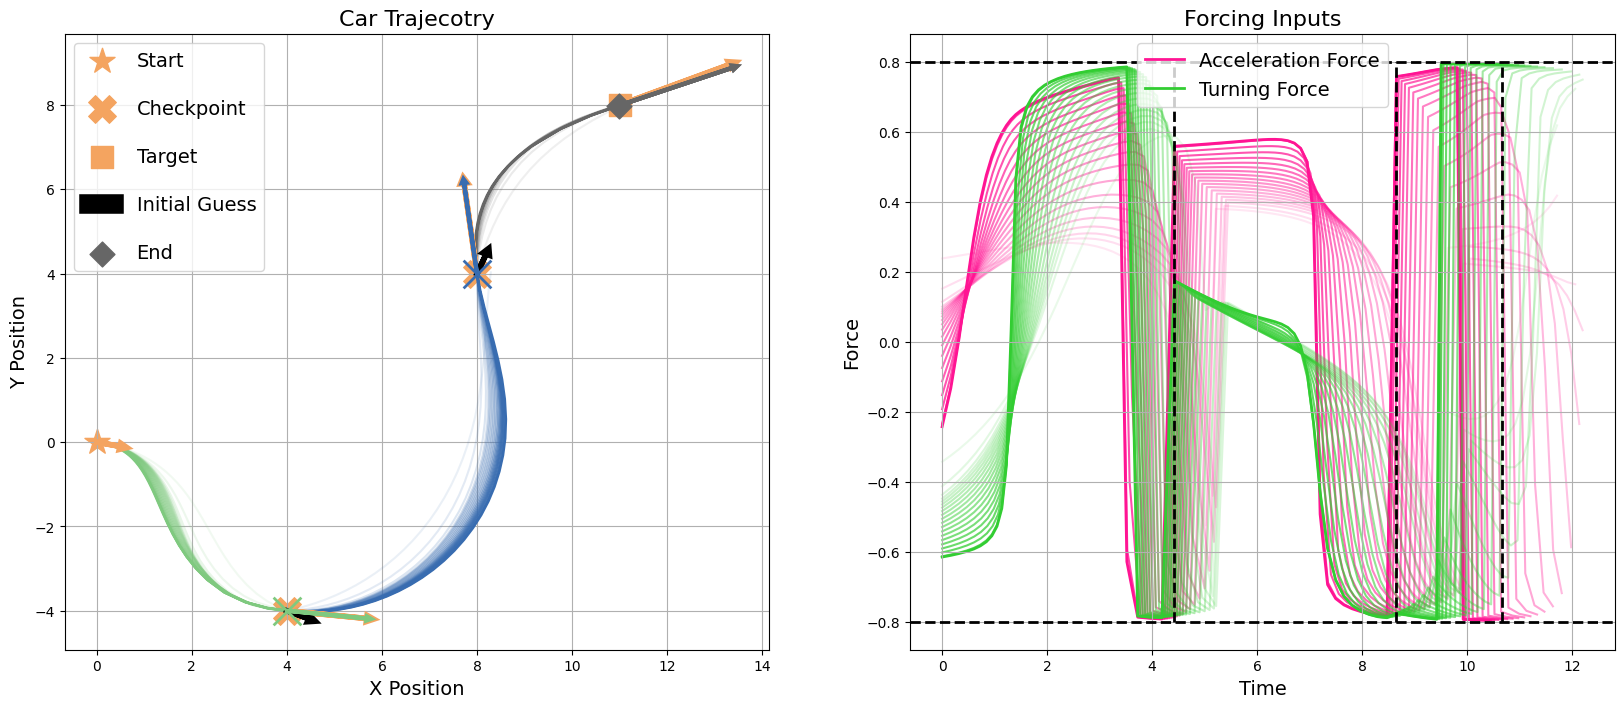

In [12]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1, cmap='Accent')
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

In [13]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[3,  2],
                           [7, 5]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = pt.tensor([32, 32, 32])

checkpoint_dof_init = pt.tensor([[0,1,-0.5],
                                 [np.pi/2, 1,0.5]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               #reverse_rate=0,
                                                                               iters=1000)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000],
        [ 7.0000,  5.0000,  1.5708,  1.0000,  0.5000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 0.797,  End Time: 14.475,  L2: 0.162,  Reverse Loss: 0.022
Iteration 100, Mean Position Dist: 0.443,  End Time: 15.289,  L2: 0.198,  Reverse Loss: 0.047
Iteration 150, Mean Position Dist: 0.365,  End Time: 15.129,  L2: 0.211,  Reverse Loss: 0.033
Iteration 200, Mean Position Dist: 0.298,  End Time: 15.105,  L2: 0.225,  Reverse Loss: 0.022
Iteration 250, Mean Position Dist: 0.238,  End Time: 15.120,  L2: 0.242,  Reverse Loss: 0.016
Iteration 300, Mean Position Dist: 0.188,  End Time: 15.144,  L2: 0.262,  Reverse Loss: 0.014
Iteration 350, Mean Position Dist: 0.149,  End Time: 15.155,  L2: 0.284,  Reverse Loss: 0.012
Iteration 400, Mean Position Dist: 0.135,  End Time: 15.119,  L2: 0.307,  Reverse Loss:

In [14]:
# speeds of final path at each timestep
pt.cat([V_mat[-1][0]] + [V_mat[-1][i][1:] for i in range(1, len(V_mat[-1]))])[:,3]

tensor([1.0000, 1.1818, 1.3624, 1.5416, 1.7190, 1.8922, 1.7714, 1.6641, 1.5630,
        1.4644, 1.3668, 1.2695, 1.1724, 1.0754, 0.9781, 0.8802, 0.7804, 0.6770,
        0.5676, 0.4523, 0.4037, 0.5130, 0.6209, 0.7333, 0.8572, 0.9950, 1.1454,
        1.3066, 1.4782, 1.6552, 1.8347, 2.0164, 2.2007, 2.2866, 2.3661, 2.4417,
        2.5133, 2.5809, 2.6444, 2.7037, 2.7588, 2.8097, 2.8563, 2.8980, 2.9323,
        2.9371, 2.8967, 2.8540, 2.8120, 2.7713, 2.7321, 2.6944, 2.6580, 2.6228,
        2.5888, 2.5558, 2.5237, 2.4925, 2.4621, 2.4324, 2.4034, 2.3748, 2.3465,
        2.3186, 2.2921, 2.4592, 2.6274, 2.7942, 2.9570, 3.0816, 2.9075, 2.7314,
        2.5539, 2.3752, 2.1956, 2.0154, 1.8348, 1.6543, 1.4739, 1.2935, 1.1135,
        0.9338, 0.7543, 0.5750, 0.3969, 0.5440, 0.6826, 0.8261, 0.9766, 1.1348,
        1.3054, 1.4788, 1.6540, 1.8302, 2.0068, 2.1837, 2.3612])

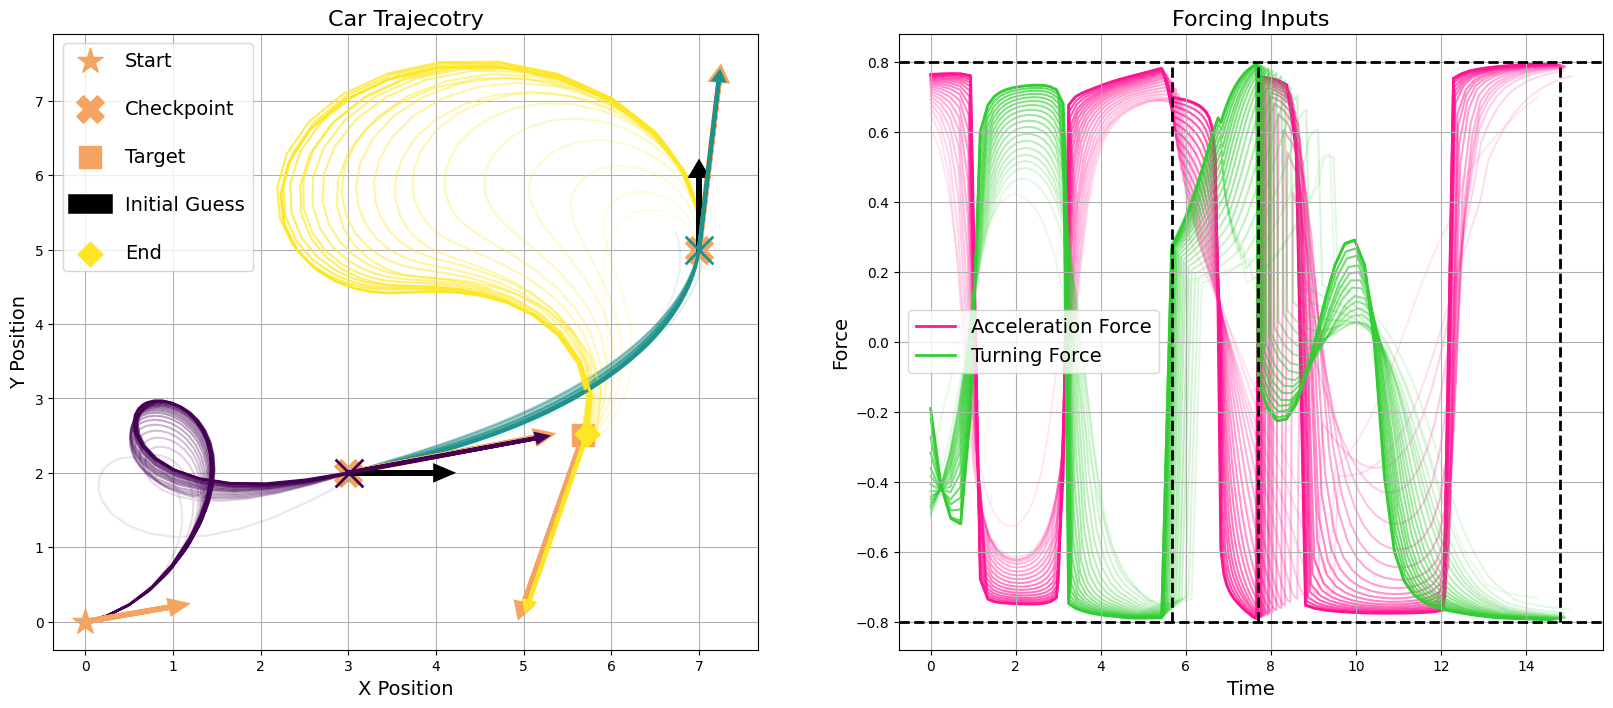

In [15]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Testing reverse loss

In [16]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])

# final conditions from multi path
#target = pt.tensor([3, 2, 0.2197, 2.2033, 0.1463])

# initialization from multi path
target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = pt.tensor([32])

#checkpoint_dof_init = pt.tensor([[0,1,-0.5],
#                                 [np.pi/2, 1,0.5]])

#checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Target: {target}\n'
    )

pt.autograd.set_detect_anomaly(False)

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               #reverse_rate=0,
                                                                               iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Target: tensor([ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000])

Iteration 50, Mean Position Dist: 1.109,  End Time: 6.274,  L2: 0.227,  Reverse Loss: 0.157
Iteration 100, Mean Position Dist: 0.551,  End Time: 6.867,  L2: 0.291,  Reverse Loss: 0.344
Iteration 150, Mean Position Dist: 0.215,  End Time: 6.810,  L2: 0.293,  Reverse Loss: 0.139
Iteration 200, Mean Position Dist: 0.107,  End Time: 6.763,  L2: 0.305,  Reverse Loss: 0.072
Iteration 250, Mean Position Dist: 0.071,  End Time: 6.687,  L2: 0.320,  Reverse Loss: 0.050
Iteration 300, Mean Position Dist: 0.054,  End Time: 6.616,  L2: 0.338,  Reverse Loss: 0.041
Iteration 350, Mean Position Dist: 0.046,  End Time: 6.553,  L2: 0.359,  Reverse Loss: 0.036
Iteration 400, Mean Position Dist: 0.044,  End Time: 6.499,  L2: 0.380,  Reverse Loss: 0.034
Iteration 450, Mean Position Dist: 0.042,  End Time: 6.454,  L2: 0.401,  Reverse Loss: 0.033
Iteration 500, Mean Position Dist: 0.

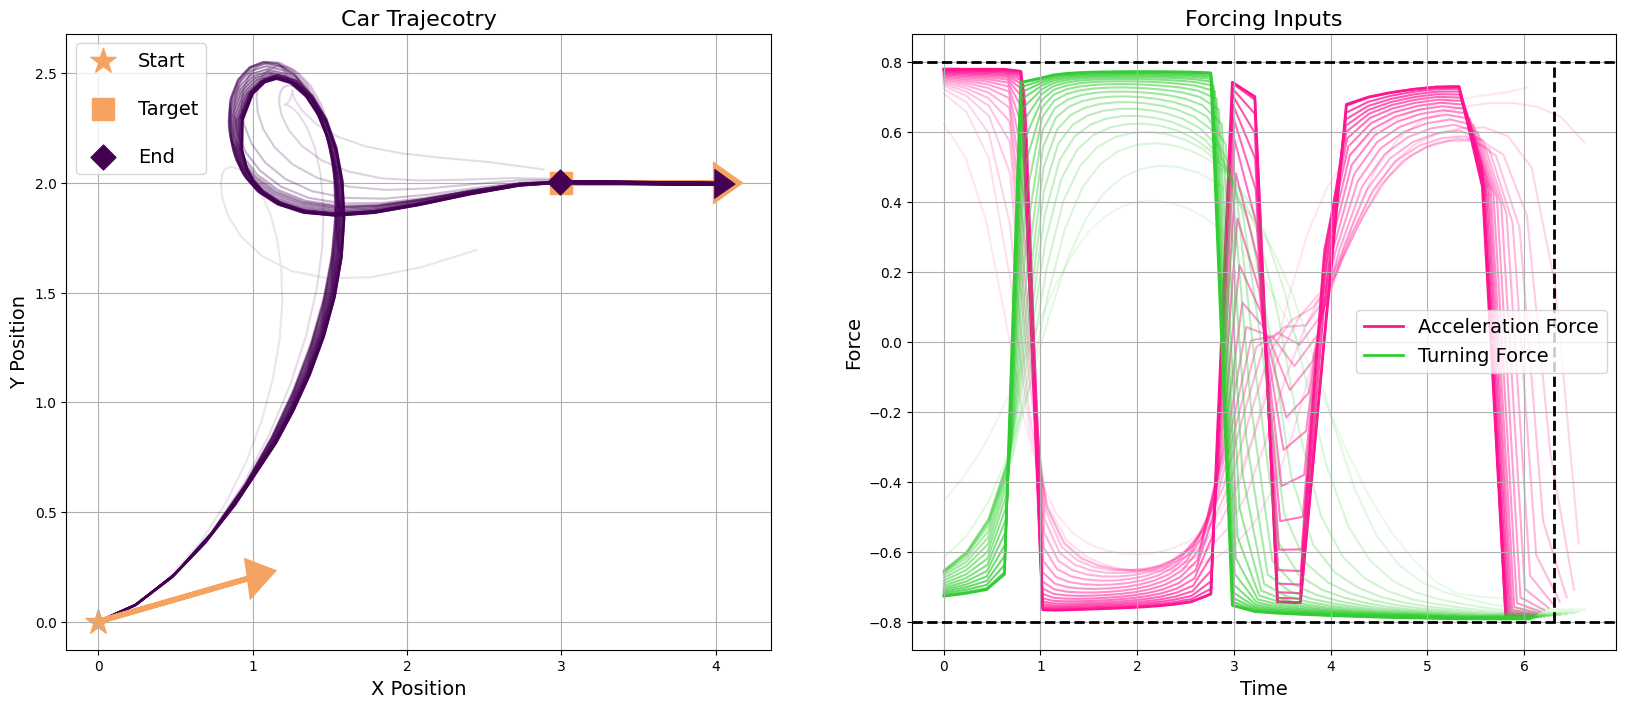

In [17]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))


plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

### Following a path (sine wave with 7 checkpoints)

In [18]:
v0 = pt.tensor([0, 0, np.pi/2, 0, 0, 0])

# sine
checkpoint_2d = pt.stack([pt.arange(np.pi/2, 4*np.pi, np.pi/2), pt.sin(pt.arange(np.pi/2, 4*np.pi, np.pi/2))], axis=1)

target = pt.tensor([4*np.pi, 0, np.pi/4, 0.5, 0.25])
n_steps = pt.tensor([32] + 7*[24])

checkpoint_dof_init = pt.tensor([[0, 0.25, -1],
                                 [-np.pi/4, 0.5, 0.5],
                                 [0, 0.25, 1],
                                 [np.pi/4, 0.5, -0.5],
                                 [0, 0.25, -1],
                                 [-np.pi/4, 0.5, -0.5],
                                 [0, 0.25, 1]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, target, F_logits,
                                                                               checkpoint_2d=checkpoint_2d,
                                                                               checkpoint_dof=checkpoint_dof,
                                                                               #plot_freq=10,
                                                                               iters=500)

segment_start = pt.cat([checkpoint_2d, checkpoint_dof], dim=1)
segment_end = pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1)

segment_diff = segment_start-segment_end

segment_diff[:,2] = angle_diff(segment_start[:,2], segment_end[:,2])

print(f'Position Differences:\n{segment_diff}')

Start: tensor([0.0000, 0.0000, 1.5708, 0.0000, 0.0000, 0.0000])
Checkpoint Guess: tensor([[ 1.5708e+00,  1.0000e+00,  0.0000e+00,  2.5000e-01, -1.0000e+00],
        [ 3.1416e+00, -8.7423e-08, -7.8540e-01,  5.0000e-01,  5.0000e-01],
        [ 4.7124e+00, -1.0000e+00,  0.0000e+00,  2.5000e-01,  1.0000e+00],
        [ 6.2832e+00,  1.7485e-07,  7.8540e-01,  5.0000e-01, -5.0000e-01],
        [ 7.8540e+00,  1.0000e+00,  0.0000e+00,  2.5000e-01, -1.0000e+00],
        [ 9.4248e+00, -2.3850e-08, -7.8540e-01,  5.0000e-01, -5.0000e-01],
        [ 1.0996e+01, -1.0000e+00,  0.0000e+00,  2.5000e-01,  1.0000e+00]])
Target: tensor([12.5664,  0.0000,  0.7854,  0.5000,  0.2500])

Iteration 50, Mean Position Dist: 0.150,  End Time: 17.968,  L2: 0.097,  Reverse Loss: 0.033
Iteration 100, Mean Position Dist: 0.080,  End Time: 17.025,  L2: 0.206,  Reverse Loss: 0.029
Iteration 150, Mean Position Dist: 0.085,  End Time: 15.924,  L2: 0.303,  Reverse Loss: 0.023
Iteration 200, Mean Position Dist: 0.087,  End T

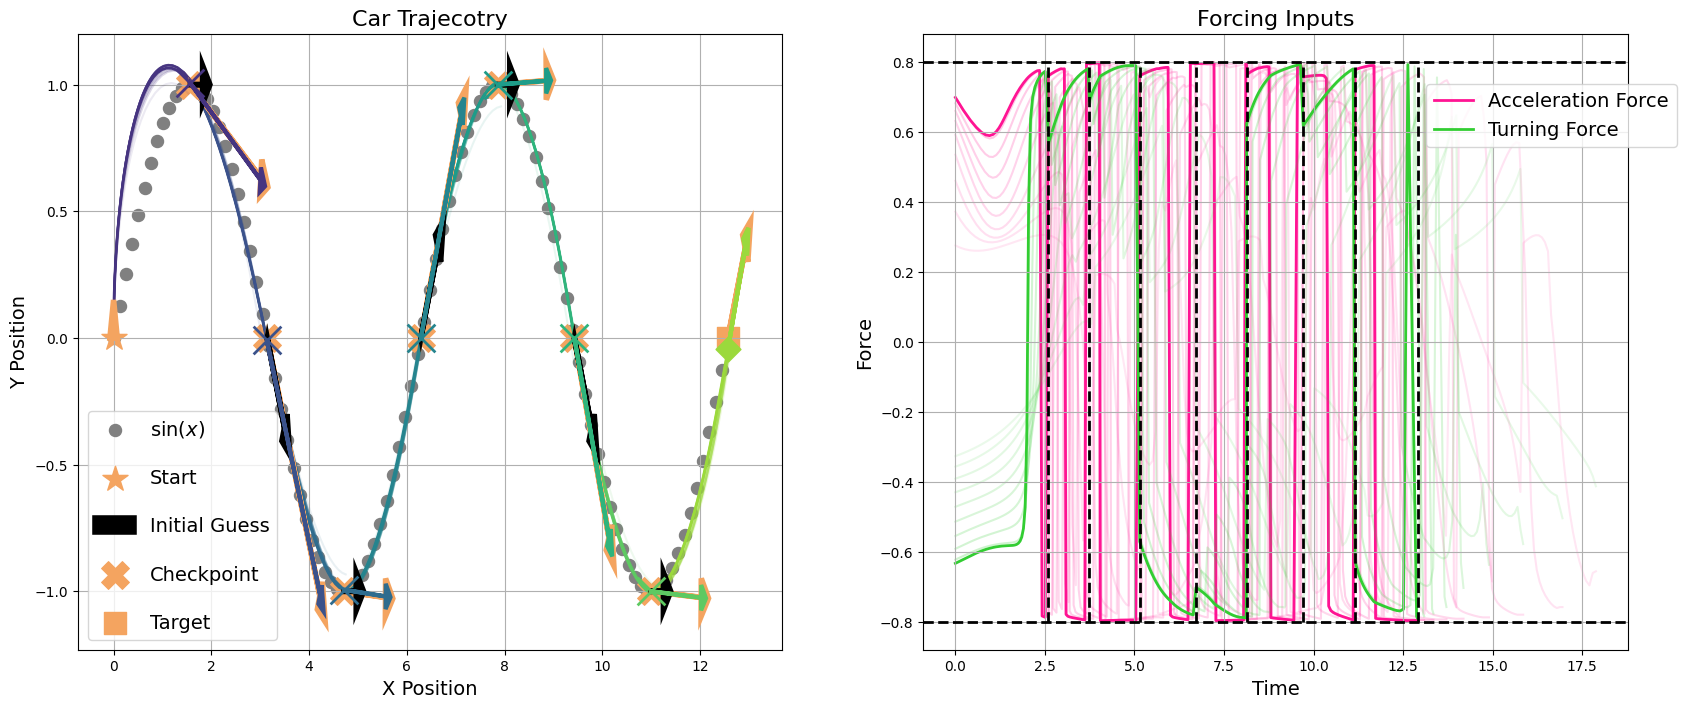

In [19]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

x=np.linspace(0,4*np.pi, 100)

ax1.scatter(x, np.sin(x), marker='.', s=300, color='grey', zorder=0, label=r'$\sin(x)$')

plot_traj(V_mat, target, 
          checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, 
          dof_init=checkpoint_dof_init, ax=ax1, vmin=0.15, vmax=0.85)

alphas = np.linspace(0.1, 0.25, num=len(ts_cat))
alphas[-1] = 1
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2, alphas=alphas)
ax2.legend(bbox_to_anchor=(0.7,0.8), fontsize=14)
plt.show()

# Plots for presentation

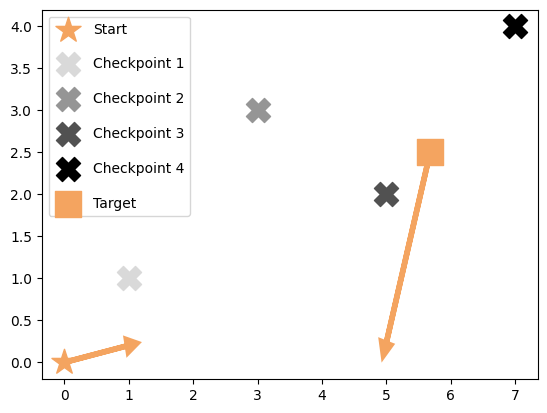

In [22]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

plt.scatter(v0[0], v0[1], marker='*', color='sandybrown', s=360, label='Start')
plt.arrow(*v0[0:2], *arrowDir(v0), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)

n_check = 5
colors = color_map(n_check, cmap_name='Greys')
ch = pt.tensor([[1,1],
                [3,3],
                [5,2],
                [7,4]])

for i in range(ch.shape[0]):
    plt.scatter(*ch[i], marker='X', s=300, color=colors[i+(n_check-ch.shape[0])], label=f'Checkpoint {i+1}')

plt.scatter(target[0], target[1], marker='s', color='sandybrown', s=360, label='Target')
plt.arrow(*target[0:2], *arrowDir(target), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)
plt.legend(labelspacing=1.5)
plt.show()

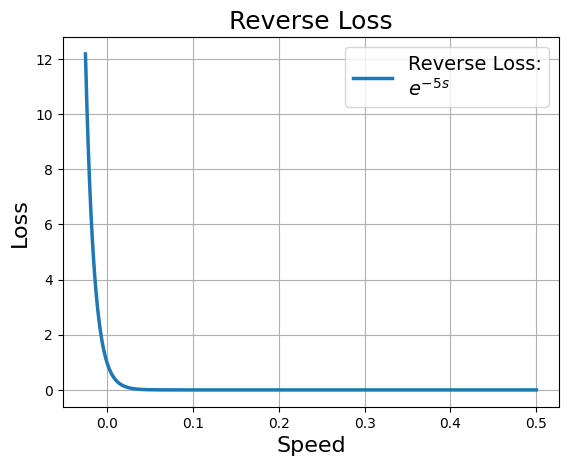

In [21]:
speeds = np.linspace(-0.025, 0.5, num=1000)
plt.plot(speeds, np.exp(-100*speeds), lw=2.5, label='Reverse Loss:\n' + r'$e^{-5s}$')
plt.grid()
plt.legend(fontsize=14)
plt.title('Reverse Loss', fontsize=18)
plt.xlabel('Speed', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#plt.yscale('log')
plt.show()